# CS 269Q: Final Project - QAOA on MIS
***
## Part 1: Using Classical Optimizer

__Note:__ Part 2: Using Grid Search is documented on another notebook.

__GOAL:__ Generate random MIS instances for simulation on the QVM and benchmark against various noise models.

## Section 1: Running on the QVM

In [1]:
from pyquil import Program, noise
from pyquil.api import WavefunctionSimulator
from pyquil.gates import H, I, RX, CNOT
from pyquil.paulis import sZ, sX, sI, exponentiate_commuting_pauli_sum
from scipy.optimize import minimize

import operator
import numpy as np
import matplotlib.pyplot as plt

### Noisless Implementation

From arXiv:1808.10816v1 [quant-ph], the variational wavefunctionn is prepared using the following hamiltonians:

$$H_p = \sum_{v \in V} -\Delta n_v + \sum_{(v,w) \in E} U n_v n_w$$

$$H_Q = \sum_{v \in V} \Omega \sigma_v^x + \sum_{(v,w) \in E} U n_v n_w$$

where $n_v = |1>_v<1| = \frac{I - \sigma_z}{2}$

__Generating Graphs:__ For the purposes of this project, I will be generating the random graphs in Wolfram Mathematica using the command `g = RandomGraph[{nodes, edges}]` and then retrieving the edge representation using `EdgeList[g]` where g is the graph I generated. I chose Mathematica, as it can be used to calculate the Maximum Independent Set of the graph using the command `Sort[FindIndependentVertexSet[g, Length /@ FindIndependentVertexSet[g], All]]` and thus verify the solution found via QAOA.

In [13]:
def elist_from_math(string: str) -> str:
    '''
    Formats the edge list provided by Mathematica.
    '''
    string = string.replace(',','), (')
    string = string.replace(' <->',',')
    return eval('(' + string + ')')

In [3]:
def get_hamil(num_nodes: int, edge_list: List[Tuple[int, int]], delta: float, 
              U: float, omega: float) -> Pauli Sum, Pauli Sum:
    '''
    For a given graph, and values of hyperparameters, returns the cost and driver Hamiltonians.
    '''
    # Mathematica labels nodes starting at 1 but we label qubits starting at 0
    nodes = list(range(0,num_nodes))
    edges = [(i-1,j-1) for i,j in edge_list]
    
    h_cost = -0.5* delta * sum((sI(i) - sZ(i)) for i in nodes) + 0.25 * U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in edges)
    h_driver = omega*sum(sX(i) for i in nodes) + 0.25*U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in edges)
    return h_cost, h_driver

In [4]:
def mis_ansatz(betas: List[float], gammas: List[float]) -> Program:
    '''
    Returns the program to create the MIS ansatz.
    '''
    pq = Program()
    pq += [exponentiate_commuting_pauli_sum(h_cost)(g) + exponentiate_commuting_pauli_sum(h_driver)(b) 
                for g, b in zip(gammas, betas)]
    return pq

In [5]:
def mis_cost(params: List[float]) -> float:
    '''
    Returns the value of the cost function given params.
    '''
    half = int(len(params)/2)
    betas, gammas = params[:half], params[half:]
    #init_state_prog = Program(RESET())
    #pq = init_state_prog + mis_ansatz(betas, gammas, h_cost, h_driver)
    pq = mis_ansatz(betas, gammas)
    return WavefunctionSimulator().expectation(prep_prog = pq, pauli_terms = h_cost)

In [6]:
def run_qaoa_mis(p: int, params: List[float], correct_state: str) -> dict key-value pair, float:
    '''
    Returns the mpost probable state and its probability, and the probability of the correct state.
    '''
    # Scaling max iterating for a given p to make a the comparison more standard
    iters = 50*p
    result = minimize(mis_cost, x0 = params, method='Nelder-Mead', options={'disp': True, 'maxiters' = iters})
    
    half = int(len(result['x'])/2)
    pq = mis_ansatz(result['x'][:half],result['x'][half:])
    
    wf_sim = WavefunctionSimulator()
    wavefunction = wf_sim.wavefunction(pq)
    prob_dict = wavefunction.get_outcome_probs() 
    sorted_dict = sorted(prob_dict.items(), key = operator.itemgetter(1))
    return sorted_dict[len(prob_dict)-1], prob_dict.get(correct_state)

In [7]:
def run_p_range(max_p: int, correct_state: str) -> List[int], List[float], List[str]:
    '''
    Runs QAOA on MIS for multiple p values from 1 to max_p.
    '''
    p_vals = []
    prob_vals = []
    colors = []
    for p in range(1, max_p + 1):
        p_vals.append(p)
        params = [0.5] * 2 * p
        result, prob_correct = run_qaoa_mis(p, params, correct)
        if (result[0] == correct):
            print("GOOD p value:", p, "with State:", result[0])        
            prob_vals.append(result[1])
            colors.append('g')
        else:
            print("BAD p value:", p, "with State:", result[0])
            prob_vals.append(prob_correct)
            colors.append('r')
    return p_vals, prob_vals, colors

#### Running QAOA on MIS

1. First we must get the edge list from Mathematica, and set the hyperparameters $\Delta, U$ and $\omega$. Also get the cost and the driver hamiltonians. 

In [8]:
elist = [(1, 4), (1, 7), (1, 8), (1, 9), (1, 10), (2, 5), (2, 6), (2, 8), (3, 4), (3, 5),
         (3, 7), (4, 7), (4, 10), (5, 6), (5, 9), (6, 7), (6, 9), (6, 10), (7, 9), (9, 10)]
# string = '1 <-> 2, 1 <-> 3, 1 <-> 4, 1 <-> 5, 2 <-> 7, 3 <-> 4, 3 <-> 7, 4 <-> 6, 4 <-> 7, 7 <-> 8' # graph2 
# string = '1 <-> 2, 1 <-> 3, 1 <-> 4, 1 <-> 5, 2 <-> 3, 2 <-> 4, 2 <-> 5, 3 <-> 4, 4 <-> 5' # graph3

# elist = elist_from_math(string)

# SET THESE PARAMS
num_nodes = 10 # update
delta = 1
U = 1.5
omega = 0.5

h_cost, h_driver = get_hamil(num_nodes, elist, delta, U, omega)

2. Ensure that you set yours parameters correctly by running QAOA for p = 2. Currently p = 1 does not result in the correct answer.

In [11]:
%%time

# check that we get the expected result
correct = '1011010000'
# correct = '10110110'
# correct = '10100'

result, prob_correct = run_qaoa_mis([0.5, 0.5, 0.5, 0.5], correct)
print(result)
print(prob_correct)

Optimization terminated successfully.
         Current function value: -1.653060
         Iterations: 115
         Function evaluations: 197
('1011010000', 0.016013513616306287)
0.016013513616306287
CPU times: user 4.38 s, sys: 74.5 ms, total: 4.46 s
Wall time: 10.6 s


3. Set the maximum p value you want to run for, and run the algorithm!

In [12]:
%%time

# SET THIS VALUE
p_max = 10

p_vals, prob_vals, colors = run_p_range(p, correct)

Optimization terminated successfully.
         Current function value: -0.833333
         Iterations: 56
         Function evaluations: 116
BAD p value: 1 with State: 0000000000
Optimization terminated successfully.
         Current function value: -1.653060
         Iterations: 115
         Function evaluations: 197
GOOD p value: 2 with State: 1011010000
Optimization terminated successfully.
         Current function value: -2.266426
         Iterations: 229
         Function evaluations: 364
GOOD p value: 3 with State: 1011010000
Optimization terminated successfully.
         Current function value: -2.461776
         Iterations: 348
         Function evaluations: 527
GOOD p value: 4 with State: 1011010000
Optimization terminated successfully.
         Current function value: -2.596553
         Iterations: 836
         Function evaluations: 1179
GOOD p value: 5 with State: 1011010000
GOOD p value: 6 with State: 1011010000
GOOD p value: 7 with State: 1011010000
GOOD p value: 8 with St

4. To see how QAOA performed on your graph, plot the results. Red color means that the most probable state was not the correct state, while green means that it was.

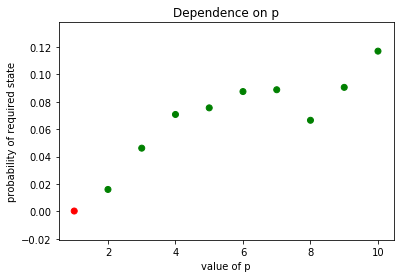

In [15]:
plt.scatter(p_vals, prob_vals, color = colors) 
plt.title("Dependence on p")
plt.xlabel("value of p")
plt.ylabel("probability of required state")
# plt.savefig("pgraph3.png")
plt.show()

In [16]:
prob_vals

[0.0002584088825309589,
 0.016013513616306287,
 0.04617072571470806,
 0.07077191741821537,
 0.07560195740556094,
 0.08751310563042256,
 0.08883531569983363,
 0.06653509811964456,
 0.09057367498538071,
 0.11702668124351008]

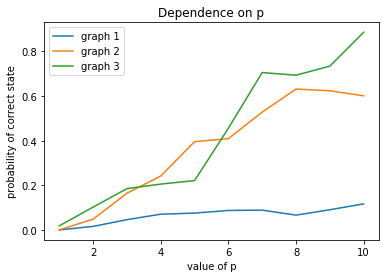

In [18]:
paxis = list(range(1,11))
plt.plot(paxis, [0.0002584088825309589, 0.016013513616306287, 0.04617072571470806, 0.07077191741821537, 0.07560195740556094,
 0.08751310563042256, 0.08883531569983363, 0.06653509811964456, 0.09057367498538071, 0.11702668124351008], label = 'graph 1') 
plt.plot(paxis, [0.0005317994423599302, 0.04844621167737637, 0.16448419711373685, 0.24162292345998884, 0.3955198436659364,
  0.409267066296394, 0.5279943164193701, 0.6313983067454861, 0.623606445096216, 0.6009971137120277], label = 'graph 2')
plt.plot(paxis, [0.018551935708694726, 0.10241589381176734, 0.1852167182088925, 0.20558281325232938, 0.2212128411269047,
 0.4559834830957632, 0.7053359374171075, 0.6933577935722443, 0.7340931703510583, 0.8858375563026535], label = 'graph 3')
plt.title("Dependence on p")
plt.xlabel("value of p")
plt.ylabel("probability of correct state")
plt.legend()
# plt.savefig("p_depth.png")
plt.show()

__I can do 5 types of analyses:__
1. Let Nealder-Mead run forever and forever
2. Stop at 100 iters
3. Grid search for params
4. Grid search with width decreasing
5. Adding noise

### Implementation with Noise

In [12]:
gate = [RX(0.6,1)]
print(gate[0].qubits)
# noisy = noise._decoherence_noise_model(gate, T1=3e-05, T2=3e-05, gate_time_1q=5e-08, gate_time_2q=1.5e-07, ro_fidelity=0.95)
# print(noisy)
print(noise.get_noisy_gate(RX(0.1,1),[1]))

[<Qubit 1>]


NoisyGateUndefined: Undefined gate and params: RX(0.1) 1(1,)
Please restrict yourself to I, RX(+/-pi), RX(+/-pi/2), CZ

In [14]:
gates = [I, RX(np.pi), RX(-np.pi), RX(np.pi/2), RX(-np.pi/2), CZ, CNOT]
noise_model = noise._decoherence_noise_model(gates, T1=3e-05, T2=3e-05, gate_time_1q=5e-08, gate_time_2q=1.5e-07, ro_fidelity=0.95)

TypeError: RX() missing 2 required positional arguments: 'angle' and 'qubit'

In [22]:
def mis_ansatz(betas, gammas):
    pq = Program()
    pq += [exponentiate_commuting_pauli_sum(h_cost)(g) + exponentiate_commuting_pauli_sum(h_driver)(b) 
                for g, b in zip(gammas, betas)]
    noise.apply_noise_model(pq, noise_model)
    return pq

In [22]:
prog = mis_ansatz([1,2],[3,4])
print(prog)

X 0
PHASE(-2.625) 0
X 0
PHASE(-2.625) 0
RZ(-6.0) 0
RZ(-6.0) 1
RZ(-3.75) 2
RZ(-6.0) 3
RZ(-3.75) 4
CNOT 0 1
RZ(2.25) 1
CNOT 0 1
CNOT 0 2
RZ(2.25) 2
CNOT 0 2
CNOT 0 3
RZ(2.25) 3
CNOT 0 3
CNOT 0 4
RZ(2.25) 4
CNOT 0 4
CNOT 1 2
RZ(2.25) 2
CNOT 1 2
CNOT 1 3
RZ(2.25) 3
CNOT 1 3
CNOT 1 4
RZ(2.25) 4
CNOT 1 4
CNOT 2 3
RZ(2.25) 3
CNOT 2 3
CNOT 3 4
RZ(2.25) 4
CNOT 3 4
H 0
RZ(1.0) 0
H 0
H 1
RZ(1.0) 1
H 1
H 2
RZ(1.0) 2
H 2
H 3
RZ(1.0) 3
H 3
H 4
RZ(1.0) 4
H 4
X 0
PHASE(-3.375) 0
X 0
PHASE(-3.375) 0
RZ(-3.0) 1
RZ(-3.0) 0
CNOT 0 1
RZ(0.75) 1
CNOT 0 1
RZ(-2.25) 2
CNOT 0 2
RZ(0.75) 2
CNOT 0 2
RZ(-3.0) 3
CNOT 0 3
RZ(0.75) 3
CNOT 0 3
RZ(-2.25) 4
CNOT 0 4
RZ(0.75) 4
CNOT 0 4
CNOT 1 2
RZ(0.75) 2
CNOT 1 2
CNOT 1 3
RZ(0.75) 3
CNOT 1 3
CNOT 1 4
RZ(0.75) 4
CNOT 1 4
CNOT 2 3
RZ(0.75) 3
CNOT 2 3
CNOT 3 4
RZ(0.75) 4
CNOT 3 4
X 0
PHASE(-3.5) 0
X 0
PHASE(-3.5) 0
RZ(-8.0) 0
RZ(-8.0) 1
RZ(-5.0) 2
RZ(-8.0) 3
RZ(-5.0) 4
CNOT 0 1
RZ(3.0) 1
CNOT 0 1
CNOT 0 2
RZ(3.0) 2
CNOT 0 2
CNOT 0 3
RZ(3.0) 3
CNOT 0 3
CNOT 0 4
RZ(3.0) 4


In [23]:
elist = [(1, 4), (1, 7), (1, 8), (1, 9), (1, 10), (2, 5), (2, 6), (2, 8), (3, 4), (3, 5),
         (3, 7), (4, 7), (4, 10), (5, 6), (5, 9), (6, 7), (6, 9), (6, 10), (7, 9), (9, 10)]
h_cost, h_driver = get_hamil(10, elist, 1, 1.5, 0.5)
run_qaoa_mis([0.5,0.5,0.5,0.5])

NoisyGateUndefined: Undefined gate and params: CNOT()
Please restrict yourself to I, RX(+/-pi), RX(+/-pi/2), CZ

In [1]:
def cnot_to_cz(pq: Program) -> Program:
    """
    :param pq:
    :return: A program that has the same operation but converts all CNOTs to CZs
    """
    prog = Program()
    for line in pq:
        if "CNOT" not in str(line): 
            prog += Program(line)
        else:
            gate, control, target = str(line).split()
            prog += Program(H(int(target)), CZ((int(control)), int(target)), H(int(target)))
                                       
    return prog

NameError: name 'Program' is not defined

## Section 2: Running on the QCS

In [ ]:
from pyquil import get_qc

### Rough Work

In [10]:
string = "1 <-> 2, 1 <-> 3, 1 <-> 4, 1 <-> 5, 2 <-> 7, 3 <-> 4, 3 <-> 7, 4 <-> 6, 4 <-> 7, 7 <-> 8"
string = string.replace(',','),(')
string.replace('<->',',')

'1 , 2),( 1 , 3),( 1 , 4),( 1 , 5),( 2 , 7),( 3 , 4),( 3 , 7),( 4 , 6),( 4 , 7),( 7 , 8'

In [3]:
#graph = [(0, 1), (0, 2), (0, 3)]
graph = [(1 , 4),( 1 , 7),( 1 , 8),( 1 , 9),( 1 , 10),( 2 , 5),( 2 , 6),( 2 , 8),( 3 , 4),( 3 , 5),
         ( 3 , 7),( 4 , 7),( 4 , 10),( 5 , 6),( 5 , 9),( 6 , 7),( 6 , 9),( 6 , 10),( 7 , 9),( 9 , 10)]
nodes = range(11)

#init_state_prog = Program(RESET())
delta = 1
U = 1.5
omega = 0.5
h_cost = -0.5* delta * sum((sI(i) - sZ(i)) for i in nodes) + 0.25 * U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in graph)
h_driver = omega*sum(sX(i) for i in nodes) + 0.25*U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in graph)

In [4]:
def mis_ansatz(betas, gammas):
    pq = Program()
    pq += [exponentiate_commuting_pauli_sum(h_cost)(g) + exponentiate_commuting_pauli_sum(h_driver)(b) 
                for g, b in zip(gammas, betas)]
    return pq

def mis_cost(params):
    half = int(len(params)/2)
    betas, gammas = params[:half], params[half:]
    #program = init_state_prog + qaoa_ansatz(betas, gammas)
    program = mis_ansatz(betas, gammas)
    return WavefunctionSimulator().expectation(prep_prog = program, pauli_terms = h_cost)

From arXiv:1808.10816v1 [quant-ph], the variational wavefunctionn is prepared using the following hamiltonians:

$$H_p = H_{cost} = \sum_{v \in V} -\Delta n_v + \sum_{(v,w) \in E} U n_v n_w$$

$$H_Q = H_{driver} = \sum_{v \in V} \Omega \sigma_v^x + \sum_{(v,w) \in E} U n_v n_w$$

where $n_v = |1>_v<1| = \frac{I - \sigma_z}{2}$

In [5]:
# %%time
result = minimize(mis_cost, x0=[1, 1, 1, 1, 1, 1], method='Nelder-Mead', options={'disp': True})

Optimization terminated successfully.
         Current function value: -3.018811
         Iterations: 505
         Function evaluations: 798


In [6]:
result

 final_simplex: (array([[ 1.02244522,  0.67252986,  0.51393121, -0.08425901, -0.3537811 ,
         0.01441819],
       [ 1.02244652,  0.67253461,  0.51393231, -0.0842919 , -0.35381464,
         0.01438602],
       [ 1.02244778,  0.67253452,  0.51391269, -0.08419627, -0.35376288,
         0.01439416],
       [ 1.02244153,  0.67255446,  0.51392772, -0.08420493, -0.35375761,
         0.0143849 ],
       [ 1.02244771,  0.67255897,  0.51391645, -0.08422519, -0.35377353,
         0.01437625],
       [ 1.02243362,  0.67255758,  0.51392511, -0.08417244, -0.35376219,
         0.01434687],
       [ 1.02245729,  0.67253653,  0.51392716, -0.08426053, -0.35379275,
         0.0143901 ]]), array([-3.01881051, -3.01881051, -3.01881051, -3.01881051, -3.01881051,
       -3.01881051, -3.01881051]))
           fun: -3.018810509386274
       message: 'Optimization terminated successfully.'
          nfev: 798
           nit: 505
        status: 0
       success: True
             x: array([ 1.02244522,  0.

In [ ]:
print(result)

In [7]:
wf_sim = WavefunctionSimulator()
pq = mis_ansatz(result['x'][:3],result['x'][3:])
wavefunction = wf_sim.wavefunction(pq)
prob_dict = wavefunction.get_outcome_probs() 

In [8]:
sorted_dict = sorted(prob_dict.items(), key = operator.itemgetter(1))
print(sorted_dict[len(prob_dict)-1])

('10110100001', 0.0388841106282332)


In [ ]:
# ('10110100001', 0.0388841106282332) p = 3, x0 = 1
# ('10110100001', 0.010002220425218854) p = 2, x0 = 0.5

In [ ]:
# The amplitudes are stored as a numpy array on the Wavefunction object
print(wavefunction.amplitudes)
prob_dict = wavefunction.get_outcome_probs() # extracts the probabilities of outcomes as a dict
print(prob_dict)
print(max(prob_dict.values()))

In [20]:
mis_cost([3.14, 3.14, 3.14, 3.14])

-5.0734525477436065e-06